In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from glob import glob
import sys

import util_tr_new as tr
from scipy import interpolate  # , signal
from scipy.signal import savgol_filter

datadir = Path("/Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/240110_#1-1392(2-3)_100um")
sample = "1392"
if not os.path.exists(datadir / sample):
    os.mkdir(datadir / sample)
savedir = datadir / sample

# RT

header: ['Time (min)', 'Temperature (K)', 'Field (Oe)', 'Position (deg)', 'Lock-in1(X)', 'Lock-in1(Y)', 'Lock-in2(X)', 'Lock-in2(Y)', 'Lock-in3(X)', 'Lock-in3(Y)', 'Lock-in4(X)', 'Lock-in4(Y)', 'Current(X)', 'Current(Y)']
current=  0.00025


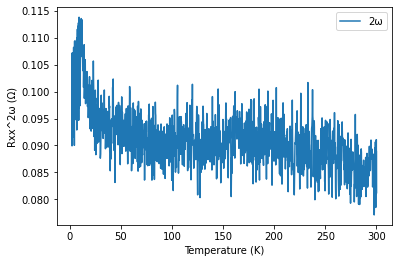

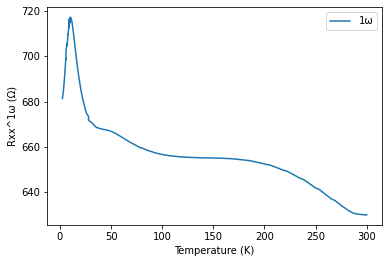

RT.csv saved


In [3]:
# RT
df_dict = {}
# for filename in sorted(glob(str(datadir / "3_14T_sweep_*e-*A.txt"))):
filename = str(datadir / "1_RT.txt")
key = Path(filename).stem
current_float = 250e-6

with open(filename, "r") as f:
    df = []
    i = 0
    while True:
        line = f.readline().strip()
        if not line:
            break
        elif i == 0:
            header = line.split("\t")
            print(f"header: {header}")
        else:
            df.append([float(x) for x in line.split("\t")])
        i += 1
df = pd.DataFrame(df, columns=header)
# df_dict[Path(filename).stem] = df
df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
df.to_csv(savedir / ("raw_RT.csv"), index=False)

B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
# fixed_temp = df["Temperature (K)"].mean()
temp = df["Temperature (K)"].values
V2omega_raw = df["Lock-in2(Y)"].values
V1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意

print("current= ", current_float)
Rxx2omega = V2omega_raw / current_float
Rxx1omega = V1omega_raw / current_float
current = np.full_like(temp, current_float)
plt.plot(temp, Rxx2omega, label="2ω")
plt.xlabel("Temperature (K)")
plt.ylabel("Rxx^2ω (Ω)")
plt.legend()
plt.show()
plt.plot(temp, Rxx1omega, label="1ω")
plt.xlabel("Temperature (K)")
plt.ylabel("Rxx^1ω (Ω)")
plt.legend()
plt.show()

new_df = pd.DataFrame({"temp": temp, "current": current, "B": B_raw, "V2omega": V2omega_raw, "V1omega": V1omega_raw, "Rxx2omega": Rxx2omega, "Rxx1omega": Rxx1omega})
new_df.to_csv(savedir / "RT.csv", index=False)
print("RT" + ".csv saved")

1_2T_sweep_250uA
------------------1_2T_sweep_250uA------------------


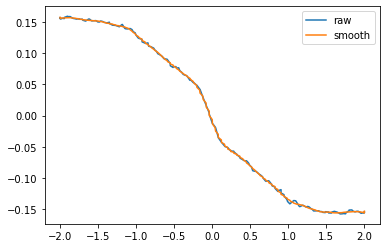

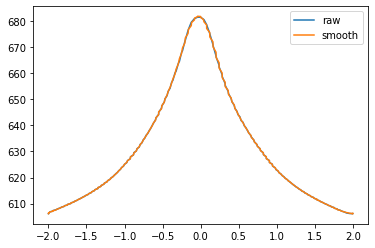

0 2.00002
R0 =  681.8019918554935 , B =  -0.039786
gamma =  -1.5180572084652708e-12


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered 

In [4]:
thickness = 20e-9  # m = 20 nm
width = 100e-6  # m = 20 um
e = 1.602e-19  # C
current_float = 250e-6  # float(key[-5:-1])

# Rxx2omegaの最大の値を計算するためのBの位置
B_Rxx2omega, thresh_Rxx2omega = 2, 0.1
# gammaを計算するためのBの位置
B_gamma, thresh_gamma = 1, 0.1

# temp_dep
df_dict = {}
for filename in sorted(glob(str(datadir / "1_2T_sweep_250uA.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline().strip()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key in df_dict.keys():
    print(f"------------------{key}------------------")
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    V2omega_raw = df["Lock-in2(Y)"].values
    # V1omega_raw = df["Lock-in1(Y)"].values
    V1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
    B_ref_u, _, V2omega_u, B_ref_d, _, V2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, V2omega_raw))
    B_ref_u, V1omega_u, _, B_ref_d, V1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, V1omega_raw))
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    Rxx2omega_u = V2omega_u / current_float
    Rxx2omega_d = V2omega_d / current_float
    Rxx1omega_u = V1omega_u / current_float
    Rxx1omega_d = V1omega_d / current_float
    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)
    plt.plot(B_ref_d, Rxx2omega_d, label="raw")
    plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_ref_d, Rxx1omega_u, label="raw")
    plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    current = np.full_like(B_ref_u, current_float)

    # Rxx2omega_dの3T前後の20点の平均，標準偏差を計算
    idx_lowB = np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega)[0][0]
    print(idx_lowB, B_ref_d[idx_lowB])
    # Rxx_3T_mean = np.mean(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    # Rxx_3T_std = np.std(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    Rxx_lowB_mean = np.mean(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_std = np.std(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_means.append(Rxx_lowB_mean)
    Rxx_lowB_stds.append(Rxx_lowB_std)
    currents.append(current_float)

    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = (Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n])
    DeltaB = (B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n])
    # print("DeltaR = ", DeltaR)
    # print("B: ", B_ref_d[idx_lowB_p], B_ref_d[idx_lowB_n])
    # print("Rxx2omega: ", Rxx2omega_d_smooth[idx_lowB_p], Rxx2omega_d_smooth[idx_lowB_n])
    current_density = current_float / (width * thickness)  # A/m^2
    # print("current_density = ", current_density)
    # R0 = 0.041106 / current_float  # Ω
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

    gamma = (DeltaR/DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)

    Rxx2omega_d_over_R0_B = Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = Rxx2omega_u_smooth / (R0 * current_density)
    new_df = pd.DataFrame({"temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, "V2omega_u": V2omega_u, "V2omega_d": V2omega_d, "V1omega_d": V1omega_d, "V1omega_u": V1omega_u, "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})

# temp dep

1_100K_sweep_250uA
1_10K_sweep_250uA
1_14K_sweep_250uA
1_20K_sweep_250uA
1_25K_sweep_250uA
1_2K_sweep_250uA
1_30K_sweep_250uA
1_40K_sweep_250uA
1_4K_sweep_250uA
1_50K_sweep_250uA
------------------1_100K_sweep_250uA------------------


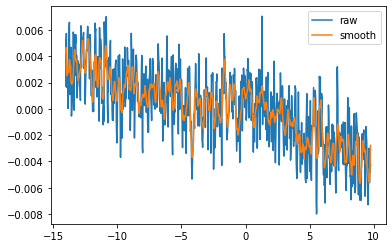

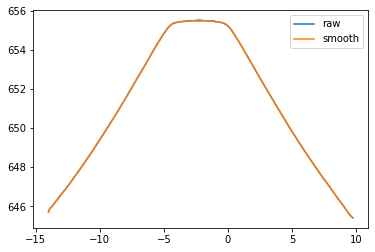

(array([366, 367, 368, 369, 370, 371, 372, 373, 374, 375]),)
366 2.08228
R0 =  655.5226931807327 , B =  -2.28575
gamma =  -7.359876643113785e-15
1_100K_sweep_250uA.csv saved
------------------1_10K_sweep_250uA------------------


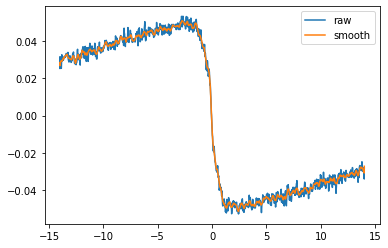

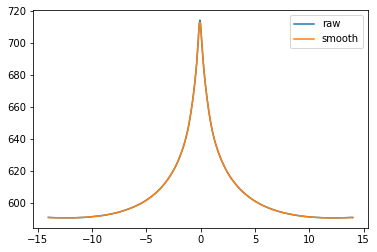

(array([614, 615, 616, 617, 618, 619, 620, 621, 622, 623]),)
614 2.07348
R0 =  713.1867296718707 , B =  -0.058126000000000004
gamma =  -4.849952847884551e-13
1_10K_sweep_250uA.csv saved
------------------1_14K_sweep_250uA------------------


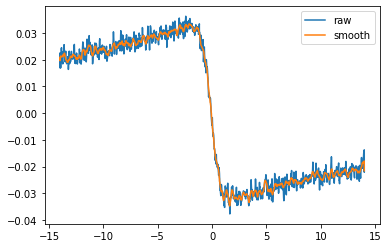

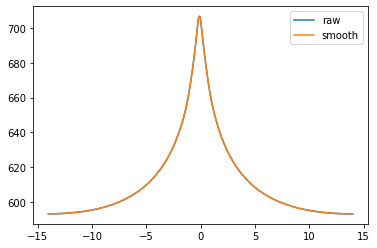

(array([594, 595, 596, 597, 598, 599, 600, 601, 602, 603]),)
594 2.08544
R0 =  706.6915505544665 , B =  -0.10576600000000001
gamma =  -3.221703730710051e-13
1_14K_sweep_250uA.csv saved
------------------1_20K_sweep_250uA------------------


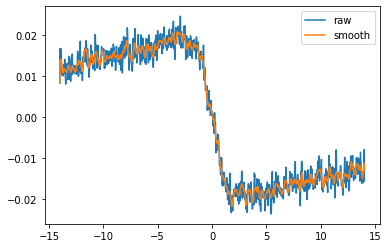

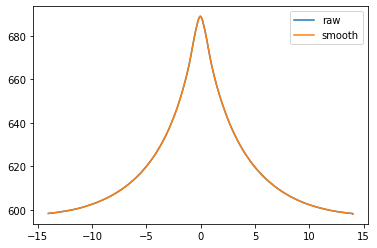

(array([594, 595, 596, 597, 598, 599, 600, 601, 602]),)
594 2.09355
R0 =  689.099439192655 , B =  -0.022669
gamma =  -1.7442852675057116e-13
1_20K_sweep_250uA.csv saved
------------------1_25K_sweep_250uA------------------


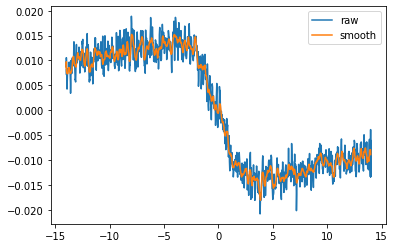

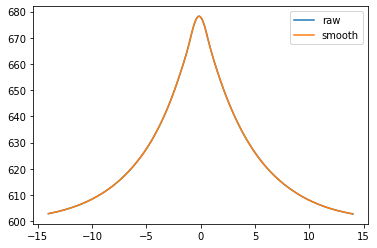

(array([598, 599, 600, 601, 602, 603, 604, 605, 606, 607]),)
598 2.0863400000000003
R0 =  678.2262773087253 , B =  -0.155354
gamma =  -7.558631514091069e-14
1_25K_sweep_250uA.csv saved
------------------1_2K_sweep_250uA------------------


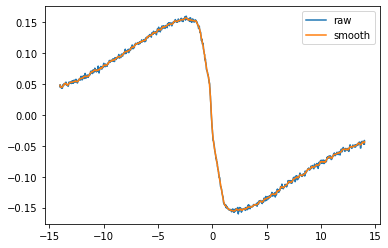

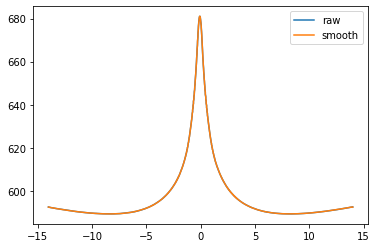

(array([608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618]),)
608 2.09689
R0 =  681.0561316943756 , B =  -0.0746798
gamma =  -1.526709263127857e-12
1_2K_sweep_250uA.csv saved
------------------1_30K_sweep_250uA------------------


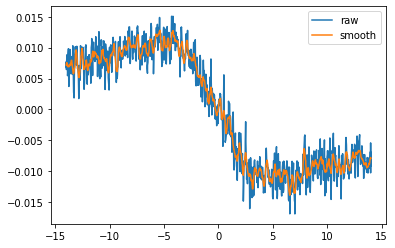

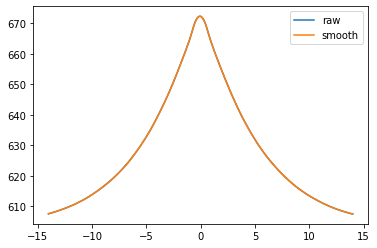

(array([574, 575, 576, 577, 578, 579, 580, 581, 582, 583]),)
574 2.08087
R0 =  672.3665841963741 , B =  -0.07282480000000001
gamma =  -1.9130520267182163e-14
1_30K_sweep_250uA.csv saved
------------------1_40K_sweep_250uA------------------


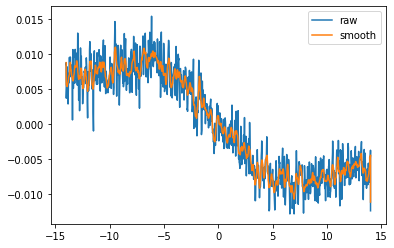

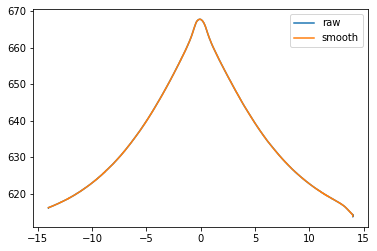

(array([581, 582, 583, 584, 585, 586, 587, 588, 589, 590]),)
581 2.0884400000000003
R0 =  667.7836547973238 , B =  -0.0628601
gamma =  -1.3899772769162617e-14
1_40K_sweep_250uA.csv saved
------------------1_4K_sweep_250uA------------------


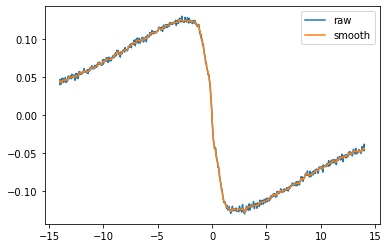

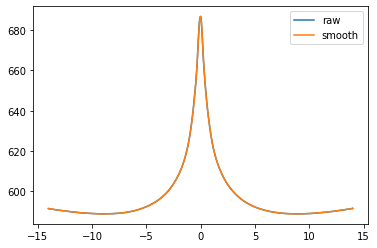

(array([604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614]),)
604 2.09654
R0 =  686.8776335647286 , B =  -0.0181813
gamma =  -1.221368827039002e-12
1_4K_sweep_250uA.csv saved
------------------1_50K_sweep_250uA------------------


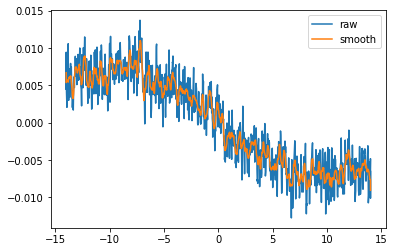

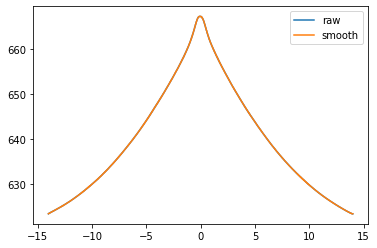

(array([587, 588, 589, 590, 591, 592, 593, 594, 595, 596]),)
587 2.09927
R0 =  667.259055872997 , B =  -0.0375706
gamma =  -3.556556938746808e-14
1_50K_sweep_250uA.csv saved
Rxx_2T_250uA_T_dep.csv saved
[99.39533220472441, 10.00023963165075, 14.000240392706871, 20.00017214741318, 25.0000624217119, 2.4499845316804407, 29.999994883040937, 39.970371965317916, 4.000042086230875, 50.00001151645208]


In [5]:
thickness = 20e-9  # m = 20 nm
width = 100e-6  # m = 20 um
e = 1.602e-19  # C
current_float = 250e-6  # float(key[-5:-1])

# Rxx2omegaの最大の値を計算するためのBの位置
B_Rxx2omega, thresh_Rxx2omega = 2, 0.1
# gammaを計算するためのBの位置
B_gamma, thresh_gamma = 1, 0.1
df_gamma_name = f"gamma_{B_gamma}T_250uA_T_dep.csv"
summary_name = f"Rxx_{B_Rxx2omega}T_250uA_T_dep.csv"


# temp_dep
df_dict = {}
for filename in sorted(glob(str(datadir / "1_*K_sweep_250uA.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline().strip()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key in df_dict.keys():
    print(f"------------------{key}------------------")
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    V2omega_raw = df["Lock-in2(Y)"].values
    # V1omega_raw = df["Lock-in1(Y)"].values
    V1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
    B_ref_u, _, V2omega_u, B_ref_d, _, V2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, V2omega_raw))
    B_ref_u, V1omega_u, _, B_ref_d, V1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, V1omega_raw))
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    Rxx2omega_u = V2omega_u / current_float
    Rxx2omega_d = V2omega_d / current_float
    Rxx1omega_u = V1omega_u / current_float
    Rxx1omega_d = V1omega_d / current_float
    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)

    plt.plot(B_ref_d, Rxx2omega_d, label="raw")
    plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_ref_d, Rxx1omega_u, label="raw")
    plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    current = np.full_like(B_ref_u, current_float)

    # Rxx2omega_dの3T前後の20点の平均，標準偏差を計算
    print(np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega))
    idx_lowB = np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega)[0][0]
    print(idx_lowB, B_ref_d[idx_lowB])
    Rxx_lowB_mean = np.mean(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_std = np.std(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_means.append(Rxx_lowB_mean)
    Rxx_lowB_stds.append(Rxx_lowB_std)
    currents.append(current_float)

    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
    DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]
    # print("DeltaR = ", DeltaR)
    # print("B: ", B_ref_d[idx_lowB_p], B_ref_d[idx_lowB_n])
    # print("Rxx2omega: ", Rxx2omega_d_smooth[idx_lowB_p], Rxx2omega_d_smooth[idx_lowB_n])
    current_density = current_float / (width * thickness)  # A/m^2
    # print("current_density = ", current_density)
    # R0 = 0.041106 / current_float  # Ω
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

    gamma = (DeltaR / DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)

    Rxx2omega_d_over_R0_B = Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = Rxx2omega_u_smooth / (R0 * current_density)

    new_df = pd.DataFrame({"temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, "V2omega_u": V2omega_u, "V2omega_d": V2omega_d, "V1omega_d": V1omega_d, "V1omega_u": V1omega_u, "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})
    new_df.to_csv(savedir / (key + ".csv"), index=False)
    print(key + ".csv saved")
    # sys.exit()
# sort by current
# sort_idx = np.argsort(currents)
# currents, Rxx_lowB_means, Rxx_lowB_stds = np.array(currents)[sort_idx], np.array(Rxx_lowB_means)[sort_idx], np.array(Rxx_lowB_stds)[sort_idx]
# df_current_dep = pd.DataFrame({"current": currents, "Rxx_lowB_mean": Rxx_lowB_means, "Rxx_lowB_std": Rxx_lowB_stds})
# df_current_dep.to_csv(savedir / f"Rxx_{lowB}T_current_dep.csv", index=False)
# print(f"Rxx_{lowB}T_current_dep.csv saved")

sort_idx = np.argsort(np.array(temps))
currents_summary, temps_summary, Rxx_lowB_means_summary, Rxx_lowB_stds_summary = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(Rxx_lowB_means)[sort_idx], np.array(Rxx_lowB_stds)[sort_idx]
df_summary = pd.DataFrame({"current": currents_summary, "temp": temps_summary, "Rxx_lowB_mean": Rxx_lowB_means_summary, "Rxx_lowB_std": Rxx_lowB_stds_summary})
df_summary.to_csv(savedir / summary_name, index=False)
print(f"{summary_name} saved")

sort_idx = np.argsort(np.array(temps))
currents_gamma, temps_gamma, gammas_gamma, R0s_gamma = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(gammas)[sort_idx], np.array(R0s)[sort_idx]
print(temps)
df_gamma = pd.DataFrame({"current": currents_gamma, "temp": temps_gamma, "gamma": gammas_gamma, "R0": R0s_gamma})
df_gamma.to_csv(savedir / df_gamma_name, index=False)

# current dep

1_9T_sweep_1000uA_2K
1_9T_sweep_100uA_2K
1_9T_sweep_250uA_2K
1_9T_sweep_500uA_2K
currents_lst = [0.001, 9.999999999999999e-05, 0.00025, 0.0005]
------------------1_9T_sweep_1000uA_2K: 0.001 A------------------


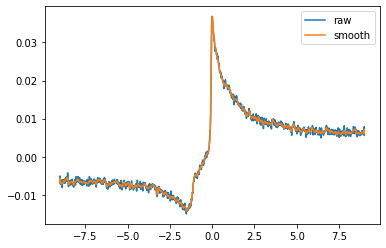

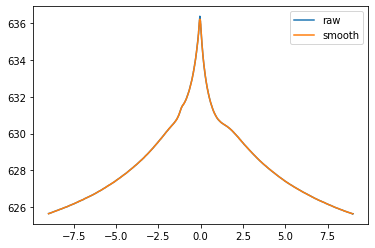

813 2.00842
R0 =  636.2131354411914 , B =  -0.0525901
gamma =  3.56511092430647e-14
1_9T_sweep_1000uA_2K.csv saved
------------------1_9T_sweep_100uA_2K: 9.999999999999999e-05 A------------------


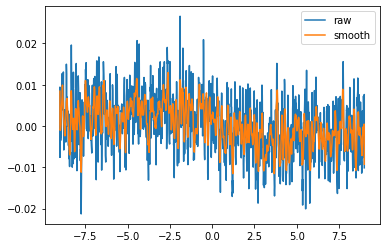

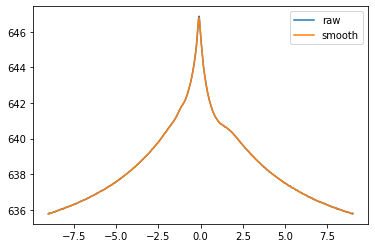

811 2.00484
R0 =  646.7869744756501 , B =  -0.10064100000000001
gamma =  -1.1697680107426417e-14
1_9T_sweep_100uA_2K.csv saved
------------------1_9T_sweep_250uA_2K: 0.00025 A------------------


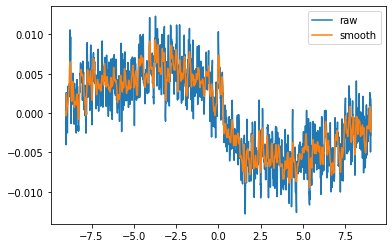

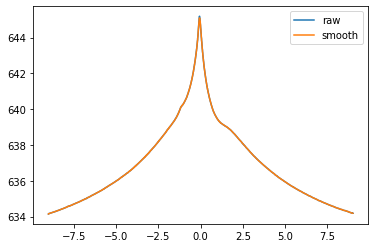

814 2.00628
R0 =  645.0977988528282 , B =  -0.059942300000000004
gamma =  -4.253069696000921e-14
1_9T_sweep_250uA_2K.csv saved
------------------1_9T_sweep_500uA_2K: 0.0005 A------------------


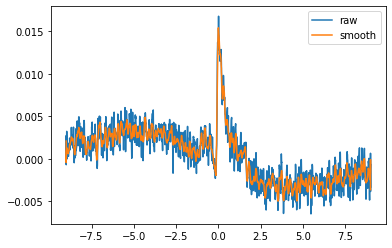

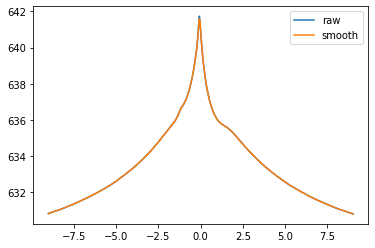

812 2.00316
R0 =  641.5910858058647 , B =  -0.0674212
gamma =  -2.0168525450784376e-15
1_9T_sweep_500uA_2K.csv saved
Rxx_2T_250uA_current_dep.csv saved
[2.44997907 2.44998656 2.44999737 2.45000232]


In [6]:
thickness = 20e-9  # m = 20 nm
width = 100e-6  # m = 20 um
e = 1.602e-19  # C
currents_lst = []  # [100e-6, 250e-6, 500e-6, 1000e-6]

# Rxx2omegaの最大の値を計算するためのBの位置
B_Rxx2omega, thresh_Rxx2omega = 2, 0.01
# gammaを計算するためのBの位置
B_gamma, thresh_gamma = 1, 0.01
df_gamma_name = f"gamma_{B_gamma}T_2K_current_dep.csv"
summary_name = f"Rxx_{B_Rxx2omega}T_2K_current_dep.csv"


# temp_dep
df_dict = {}
for filename in sorted(glob(str(datadir / "1_9T_sweep_*uA_2K.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline().strip()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df
    currents_lst.append(float(Path(filename).stem.split("_")[3][:-2]) * 1e-6)
print(f"currents_lst = {currents_lst}")

# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key, current_float in zip(df_dict.keys(), currents_lst):
    print(f"------------------{key}: {current_float} A------------------")
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    V2omega_raw = df["Lock-in2(Y)"].values
    # V1omega_raw = df["Lock-in1(Y)"].values
    V1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
    B_ref_u, _, V2omega_u, B_ref_d, _, V2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, V2omega_raw))
    B_ref_u, V1omega_u, _, B_ref_d, V1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, V1omega_raw))
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    Rxx2omega_u = V2omega_u / current_float
    Rxx2omega_d = V2omega_d / current_float
    Rxx1omega_u = V1omega_u / current_float
    Rxx1omega_d = V1omega_d / current_float
    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)
    plt.plot(B_ref_d, Rxx2omega_d, label="raw")
    plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_ref_d, Rxx1omega_u, label="raw")
    plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    current = np.full_like(B_ref_u, current_float)

    # Rxx2omega_dのB_rxx2omega前後の20点の平均，標準偏差を計算
    idx_lowB = np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega)[0][0]
    print(idx_lowB, B_ref_d[idx_lowB])
    # Rxx_3T_mean = np.mean(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    # Rxx_3T_std = np.std(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    Rxx_lowB_mean = np.mean(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_std = np.std(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_means.append(Rxx_lowB_mean)
    Rxx_lowB_stds.append(Rxx_lowB_std)
    currents.append(current_float)

    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
    DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]
    # print("DeltaR = ", DeltaR)
    # print("B: ", B_ref_d[idx_lowB_p], B_ref_d[idx_lowB_n])
    # print("Rxx2omega: ", Rxx2omega_d_smooth[idx_lowB_p], Rxx2omega_d_smooth[idx_lowB_n])
    current_density = current_float / (width * thickness)  # A/m^2
    # print("current_density = ", current_density)
    # R0 = 0.041106 / current_float  # Ω
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

    gamma = (DeltaR / DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)

    Rxx2omega_d_over_R0_B = Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = Rxx2omega_u_smooth / (R0 * current_density)

    new_df = pd.DataFrame({"temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, "V2omega_u": V2omega_u, "V2omega_d": V2omega_d, "V1omega_d": V1omega_d, "V1omega_u": V1omega_u, "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})
    new_df.to_csv(savedir / (key + ".csv"), index=False)
    print(key + ".csv saved")

sort_idx = np.argsort(np.array(temps))
temps, Rxx_lowB_means, Rxx_lowB_stds = np.array(temps)[sort_idx], np.array(Rxx_lowB_means)[sort_idx], np.array(Rxx_lowB_stds)[sort_idx]
df_summary = pd.DataFrame({"current": currents, "temp": temps, "Rxx_lowB_mean": Rxx_lowB_means, "Rxx_lowB_std": Rxx_lowB_stds})
df_summary.to_csv(savedir / summary_name, index=False)
print(f"{summary_name} saved")

sort_idx = np.argsort(np.array(temps))
temps, gammas, R0s = np.array(temps)[sort_idx], np.array(gammas)[sort_idx], np.array(R0s)[sort_idx]
print(temps)
df_gamma = pd.DataFrame({"current": currents, "temp": temps, "gamma": gammas, "R0": R0s})
df_gamma.to_csv(savedir / df_gamma_name, index=False)